# 01-intro: Homework

The goal of this homework is to train a simple model for predicting the duration of a ride - similar to what we did in this module.



In [64]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

## Q1. Downloading the data

We'll use [the same NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page), but instead of "Green Taxi Trip Records", we'll use "Yellow Taxi Trip Records".

Download the data for January and February 2023.

Read the data for January. How many columns are there?

In [65]:
tripdata_202101_df = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')
tripdata_202102_df = pd.read_parquet('./data/yellow_tripdata_2023-02.parquet')

In [66]:
print(tripdata_202101_df.shape)
display(tripdata_202101_df.head())

(3066766, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


## Q2. Computing duration

Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the standard deviation of the trips duration in January?



In [67]:
tripdata_202101_df["duration"] = tripdata_202101_df.tpep_dropoff_datetime - tripdata_202101_df.tpep_pickup_datetime
tripdata_202101_df["duration"] = tripdata_202101_df['duration'].dt.total_seconds() / 60
tripdata_202101_df.duration.std()

42.59435124195458

## Q3. Dropping outliers
Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?



In [68]:
tripdata_202101_filtered_df = tripdata_202101_df[(tripdata_202101_df["duration"] >= 1) & (tripdata_202101_df["duration"] <= 60)]
len(tripdata_202101_filtered_df) / len(tripdata_202101_df)

0.9812202822125979

## Q4. One-hot encoding
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
Fit a dictionary vectorizer
Get a feature matrix from it
What's the dimensionality of this matrix (number of columns)?



In [69]:
locations_202101_dict = tripdata_202101_filtered_df[["PULocationID", "DOLocationID"]].astype(str).to_dict(orient="records")
dv = DictVectorizer()
X_train = dv.fit_transform(locations_202101_dict)
X_train.shape

(3009173, 515)

## Q5. Training a model
Now let's use the feature matrix from the previous step to train a model.

Train a plain linear regression model with default parameters
Calculate the RMSE of the model on the training data
What's the RMSE on train?



In [70]:
y_train = tripdata_202101_filtered_df["duration"].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred)
rmse_train = mse_train ** 0.5
print(rmse_train)

7.649261927686161


## Q6. Evaluating the model
Now let's apply this model to the validation dataset (February 2023).

What's the RMSE on validation?



In [73]:
tripdata_202102_df["duration"] = tripdata_202102_df.tpep_dropoff_datetime - tripdata_202102_df.tpep_pickup_datetime
tripdata_202102_df["duration"] = tripdata_202102_df["duration"].dt.total_seconds() / 60
tripdata_202102_filtered_df = tripdata_202102_df[(tripdata_202102_df["duration"] >= 1) & (tripdata_202102_df["duration"] <= 60)]
locations_202102_dict = tripdata_202102_filtered_df[["PULocationID", "DOLocationID"]].astype(str).to_dict(orient="records")

X_val = dv.transform(locations_202102_dict)
y_val = tripdata_202102_filtered_df["duration"].values

y_val_pred = lr.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = mse_val ** 0.5
print(rmse_val)

7.811817957524739


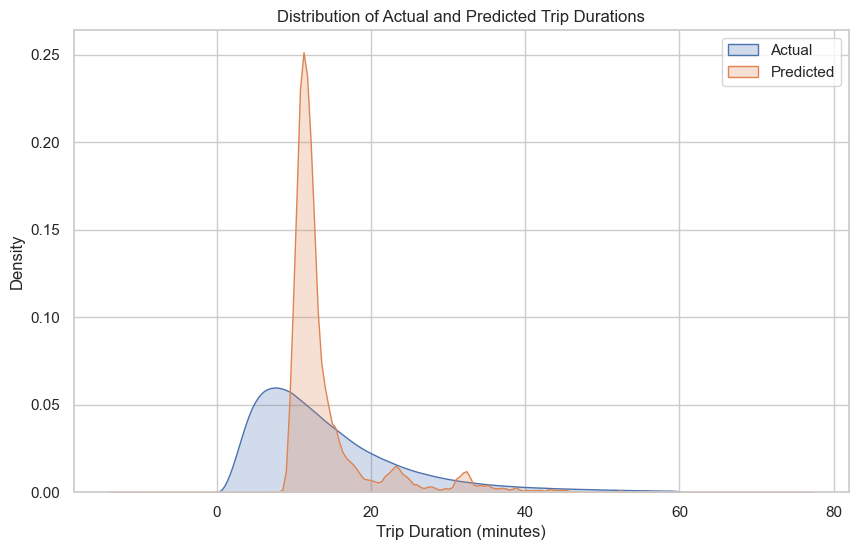

In [74]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.kdeplot(y_val, label="Actual", fill=True)
sns.kdeplot(y_val_pred, label="Predicted", fill=True)
plt.title("Distribution of Actual and Predicted Trip Durations")
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Density")
plt.legend()
plt.show()